In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import PIL
from PIL import Image
import os
import torchvision
from torchvision import transforms as tvt
import torch
from torch import optim
from torch.nn import parallel
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import random
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import pylab
import pathlib
import random
import skimage
import cv2
from torchvision import ops
import time

In [ ]:
!unzip /content/train_val_compressed.zip -d /content/

Streaming output truncated to the last 5000 lines.
  inflating: /content/train/airplane/COCO_train2014_000000360606.jpg  
  inflating: /content/train/airplane/COCO_train2014_000000141664.jpg  
  inflating: /content/train/airplane/COCO_train2014_000000303376.jpg  
  inflating: /content/train/airplane/COCO_train2014_000000172537.jpg  
  inflating: /content/train/airplane/COCO_train2014_000000303404.jpg  
  inflating: /content/train/airplane/COCO_train2014_000000125335.jpg  
  inflating: /content/train/airplane/COCO_train2014_000000071016.jpg  
  inflating: /content/train/airplane/COCO_train2014_000000075927.jpg  
  inflating: /content/train/airplane/COCO_train2014_000000471008.jpg  
  inflating: /content/train/airplane/COCO_train2014_000000574602.jpg  
  inflating: /content/train/airplane/COCO_train2014_000000413869.jpg  
  inflating: /content/train/airplane/COCO_train2014_000000521165.jpg  
  inflating: /content/train/airplane/COCO_train2014_000000470458.jpg  
  inflating: /content/trai

In [ ]:
class PatchEmbed(nn.Module): #Note, from Meta DINO ViT code ()
    """ Image to Patch Embedding
    """
    def __init__(self, img_size=64, patch_size=16, in_chans=3, embed_dim=512):
        super().__init__()
        num_patches = (img_size // patch_size) * (img_size // patch_size)
        self.img_size = img_size
        self.patch_size = patch_size
        self.num_patches = num_patches

        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)
        
    def forward(self, x):
        B, C, H, W = x.shape
        y = self.proj(x)
        #print('conv output before flattening and transpose', y.shape)
        x = self.proj(x).flatten(2).transpose(1, 2)
        return x

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class MasterEncoder(nn.Module):
    def __init__(self, max_seq_length, embedding_size, how_many_basic_encoders, num_atten_heads):
        super().__init__()
        self.class_embedding = nn.Parameter(torch.rand(size = (1, 1, embedding_size))) #create class embedding.
        #this class_embedding will be the first row of the embedding matrix, where axis 0 is each patch embedding
        #Note that the first 1 in the size parameter above corresponds to the batch size. 
        self.pos_embedding = nn.Parameter(torch.rand(size = (1, max_seq_length, embedding_size)))
        self.patch_generator = PatchEmbed()
        self.max_seq_length = max_seq_length
        self.basic_encoder_arr = nn.ModuleList([BasicEncoder(
            max_seq_length, embedding_size, num_atten_heads) for _ in range(how_many_basic_encoders)])  # (A)
        self.mlp_head = nn.Linear(embedding_size, 5)

    def forward(self, img_patch): 
        #out_tensor = sentence_tensor
        img_embedding = self.patch_generator(img_patch) #pass in img_patch, which has convo2d applied to it and 
        #results in the img embedding.
        
        img_embedding = torch.cat(tensors = (self.class_embedding, img_embedding), dim = 1)
        img_embedding = img_embedding + self.pos_embedding
        for i in range(len(self.basic_encoder_arr)):  # (B)
            img_embedding = self.basic_encoder_arr[i](img_embedding)
        

        img_embedding = self.mlp_head(img_embedding[0,0,:]) #use the class embedding vector to do the prediction.
        #here, we take the 100-dimension embedding to 5d, so we can get log probabilities and then do NLLLoss
        # all using CE loss in the training loop. 
        return img_embedding


class BasicEncoder(nn.Module):
    def __init__(self, max_seq_length, embedding_size, num_atten_heads):
        super().__init__()
        self.max_seq_length = max_seq_length
        self.embedding_size = embedding_size
        self.qkv_size = self.embedding_size // num_atten_heads
        self.num_atten_heads = num_atten_heads
        self.self_attention_layer = SelfAttention(
            max_seq_length, embedding_size, num_atten_heads)  # (A)
        self.norm1 = nn.LayerNorm(self.embedding_size)  # (C)
        self.W1 = nn.Linear(self.max_seq_length * self.embedding_size,
                            self.max_seq_length * 2 * self.embedding_size)
        self.W2 = nn.Linear(self.max_seq_length * 2 * self.embedding_size,
                            self.max_seq_length * self.embedding_size)
        self.norm2 = nn.LayerNorm(self.embedding_size)  # (E)

    def forward(self, sentence_tensor):
        input_for_self_atten = sentence_tensor.float()
        normed_input_self_atten = self.norm1(input_for_self_atten)
        output_self_atten = self.self_attention_layer(
            normed_input_self_atten).to(device)  # (F)
        input_for_FFN = output_self_atten + input_for_self_atten
        normed_input_FFN = self.norm2(input_for_FFN)  # (I)
        basic_encoder_out = nn.ReLU()(
            self.W1(normed_input_FFN.view(sentence_tensor.shape[0], -1)))  # (K)
        basic_encoder_out = self.W2(basic_encoder_out)  # (L)
        basic_encoder_out = basic_encoder_out.view(
            sentence_tensor.shape[0], self.max_seq_length, self.embedding_size)
        basic_encoder_out = basic_encoder_out + input_for_FFN
        return basic_encoder_out
    

        
####################################  Self Attention Code TransformerPreLN ###########################################

class SelfAttention(nn.Module):
    def __init__(self, max_seq_length, embedding_size, num_atten_heads):
        super().__init__()
        self.max_seq_length = max_seq_length
        self.embedding_size = embedding_size
        self.num_atten_heads = num_atten_heads
        self.qkv_size = self.embedding_size // num_atten_heads
        self.attention_heads_arr = nn.ModuleList([AttentionHead(self.max_seq_length,
                                                                self.qkv_size) for _ in range(num_atten_heads)])  # (A)

    def forward(self, sentence_tensor):  # (B)
        concat_out_from_atten_heads = torch.zeros(sentence_tensor.shape[0], self.max_seq_length,
                                                  self.num_atten_heads * self.qkv_size).float()
        for i in range(self.num_atten_heads):  # (C)
            sentence_tensor_portion = sentence_tensor[:,
                                                      :, i * self.qkv_size: (i+1) * self.qkv_size]
            concat_out_from_atten_heads[:, :, i * self.qkv_size: (i+1) * self.qkv_size] =          \
                self.attention_heads_arr[i](sentence_tensor_portion)  # (D)
        return concat_out_from_atten_heads


        
    
class AttentionHead(nn.Module):
    def __init__(self, max_seq_length, qkv_size):
        super().__init__()
        self.qkv_size = qkv_size
        self.max_seq_length = max_seq_length
        self.WQ = nn.Linear(max_seq_length * self.qkv_size,
                            max_seq_length * self.qkv_size)  # (B)
        self.WK = nn.Linear(max_seq_length * self.qkv_size,
                            max_seq_length * self.qkv_size)  # (C)
        self.WV = nn.Linear(max_seq_length * self.qkv_size,
                            max_seq_length * self.qkv_size)  # (D)
        self.softmax = nn.Softmax(dim=1)  # (E)

    def forward(self, sentence_portion):  # (F)
        Q = self.WQ(sentence_portion.reshape(
            sentence_portion.shape[0], -1).float()).to(device)  # (G)
        K = self.WK(sentence_portion.reshape(
            sentence_portion.shape[0], -1).float()).to(device)  # (H)
        V = self.WV(sentence_portion.reshape(
            sentence_portion.shape[0], -1).float()).to(device)  # (I)
        Q = Q.view(sentence_portion.shape[0],
                   self.max_seq_length, self.qkv_size)  # (J)
        K = K.view(sentence_portion.shape[0],
                   self.max_seq_length, self.qkv_size)  # (K)
        V = V.view(sentence_portion.shape[0],
                   self.max_seq_length, self.qkv_size)  # (L)
        A = K.transpose(2, 1)  # (M)
        QK_dot_prod = Q @ A  # (N)
        rowwise_softmax_normalizations = self.softmax(QK_dot_prod)  # (O)
        Z = rowwise_softmax_normalizations @ V
        coeff = 1.0/torch.sqrt(torch.tensor([self.qkv_size]).float()).to(device)  # (S)
        Z = coeff * Z  # (T)
        return Z

In [ ]:
os.getcwd()
root = '.'
root_train = 'train/'
root_val = 'val/'
catNms=['airplane','bus','cat', 'dog', 'pizza']
os.chdir(root)  

In [ ]:
### Create data_loader ### 
root_train = 'train/'
root_val = 'val/'
catNms=['airplane','bus','cat', 'dog', 'pizza']

class MyDataset(torch.utils.data.Dataset):
    def __init__(self, root, catNms):
        super(MyDataset).__init__()
        self.root = {} #dictionary for main directory which holds all the images of a category
        self.filenames = {} #dictionary for filenames of a given category
        for cat in catNms:
            self.root[cat] = root + cat + '/'
        for cat in catNms:
        #create list of image files in each category that can be opened by __getitem__
            self.filenames[cat] = os.listdir(self.root[cat])
        
        self.rand_max = len(os.listdir(self.root[catNms[0]])) - 1 #number of files in directory

        self.mapping = {0 : 'airplane',
                        1: 'bus',
                        2: 'cat',
                        3: 'dog',
                        4: 'pizza'} #makes it easy to convert between index and name of a category.
        
        self.one_hot_encoding = {0: torch.tensor(np.array([1, 0, 0, 0, 0])),
                                1: torch.tensor(np.array([0, 1, 0, 0, 0])),
                                2: torch.tensor(np.array([0, 0, 1, 0, 0])),
                                3: torch.tensor(np.array([0, 0, 0, 1, 0])),
                                4: torch.tensor(np.array([0, 0, 0, 0, 1]))} #one hot encode each category. 

        if (root == 'train/'):
          self.to_Tensor_and_Norm = tvt.Compose([tvt.ToTensor(),tvt.Resize((64,64)) , 
                                          tvt.Normalize([0], [1]) ,  tvt.ColorJitter(0.75, 0.75) , 
                                          tvt.RandomHorizontalFlip( p = 0.75), 
                                          tvt.RandomRotation(degrees = 45)]) #normalize and resize in case the resize op 
  #         wasn't done. Note that resizing here may not have any impact as the resizing was done previously. 

        if (root == 'val/'):  
          self.to_Tensor_and_Norm = tvt.Compose([tvt.ToTensor(),tvt.Resize((64,64)) , 
                                          tvt.Normalize([0], [1])]) #no need for all the other transforms 


    def __len__(self):
        count = 0
        for cat in catNms:
            temp_num = os.listdir(self.root[cat])
            count = count + len(temp_num)
        return count #. Will be 2500 if the root=val/ and 7500 if root=train/

    def __getitem__(self, index):
        file_index = index % self.rand_max + 1
        class_index = index % 5
 
        img_file = self.filenames[self.mapping[class_index]]
        
        try:
            item = Image.open(self.root[self.mapping[class_index]] + img_file[file_index])
        except IndexError: #for debugging
            print('these are the indices for the line above when shape is correct', class_index , file_index)
            
        np_img = np.array(item)
        shape = np_img.shape
        while shape != (64, 64 ,3): #handle if the image from COCO is grayscale. 
            #print('found a grayscale image, fetching an RGB!')
            another_rand = random.randint(0,self.rand_max)  #generate another rand num
            #print('another_rand is', another_rand)
            try:
                item = Image.open(self.root[self.mapping[class_index]] + img_file[another_rand])
            except IndexError: #for debugging
                print('these are the indices for the line above when shape is incorrect', another_rand , class_index)            
            np_img = np.array(item)
            shape = np_img.shape

        img = self.to_Tensor_and_Norm(item)
        class_label = self.one_hot_encoding[class_index].type(torch.FloatTensor) #convert to Float 
        return img, class_label


my_train_dataset = MyDataset(root_train, catNms)
print(len(my_train_dataset))
index = 100
print(my_train_dataset[index][0].shape, my_train_dataset[index][1])
my_val_dataset = MyDataset(root_val, catNms)
print(len(my_val_dataset))
print(my_val_dataset[index][0].shape, my_val_dataset[index][1])

7500
torch.Size([3, 64, 64]) tensor([1., 0., 0., 0., 0.])
2500
torch.Size([3, 64, 64]) tensor([1., 0., 0., 0., 0.])


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [ ]:
# Use MyDataset class in PyTorches DataLoader functionality
batch_size = 1
my_train_dataloader = torch.utils.data.DataLoader(my_train_dataset, batch_size=batch_size, num_workers = 1, drop_last=True)
my_val_dataloader = torch.utils.data.DataLoader(my_val_dataset, batch_size = batch_size, num_workers = 1, drop_last = True)


# for n, data in enumerate(my_train_dataloader):
#     print(n)



In [ ]:
epochs = 10
criterion = nn.CrossEntropyLoss()
encoder = MasterEncoder(max_seq_length=17, embedding_size=512, how_many_basic_encoders=4, num_atten_heads=8)
optimizer = torch.optim.Adam(encoder.parameters(), lr = 1e-3, betas = (0.9, 0.99))
loss_running_list_encoder = []
running_loss = 0.0
encoder = encoder.to(device)
for i in range(epochs):
    for n, data in enumerate(my_train_dataloader):
        #Create encoder network:
        #print(n)
        optimizer.zero_grad() #Sets gradients of all model parameters to zero. We want to compute fresh gradients
        #based on the new forward run. 
        img, GT = data
        GT = torch.argmax(GT)

        img = img.to(device)
        GT = GT.to(device)
        
        out = encoder(img)
        loss = criterion(out, GT) #input, then target for arg order
        
        loss.backward() #compute derivative of loss wrt each gradient. 
        optimizer.step() #takes a step on hyperplane based on derivatives
        running_loss += loss.item() 
        if (n+1) % 500 == 0:
            print("[epoch: %d, batch: %5d] loss: %3f" % (i + 1, n + 1, running_loss / 500))
            loss_running_list_encoder.append(running_loss/500)
            running_loss = 0.0
    
        
        
        

[epoch: 1, batch:   500] loss: 17.941827
[epoch: 1, batch:  1000] loss: 1.677769
[epoch: 1, batch:  1500] loss: 1.575642
[epoch: 1, batch:  2000] loss: 1.543881
[epoch: 1, batch:  2500] loss: 1.493334
[epoch: 1, batch:  3000] loss: 1.516270
[epoch: 1, batch:  3500] loss: 1.537413
[epoch: 1, batch:  4000] loss: 1.471997
[epoch: 1, batch:  4500] loss: 1.551694
[epoch: 1, batch:  5000] loss: 1.499149
[epoch: 1, batch:  5500] loss: 1.473189
[epoch: 1, batch:  6000] loss: 1.505093
[epoch: 1, batch:  6500] loss: 1.487909
[epoch: 1, batch:  7000] loss: 1.484909
[epoch: 1, batch:  7500] loss: 1.457154
[epoch: 2, batch:   500] loss: 1.450734
[epoch: 2, batch:  1000] loss: 1.425012
[epoch: 2, batch:  1500] loss: 1.506899
[epoch: 2, batch:  2000] loss: 1.415097
[epoch: 2, batch:  2500] loss: 1.404979
[epoch: 2, batch:  3000] loss: 1.459686
[epoch: 2, batch:  3500] loss: 1.461010
[epoch: 2, batch:  4000] loss: 1.429671
[epoch: 2, batch:  4500] loss: 1.450500
[epoch: 2, batch:  5000] loss: 1.461117

Text(0, 0.5, 'Cross Entropy Loss')

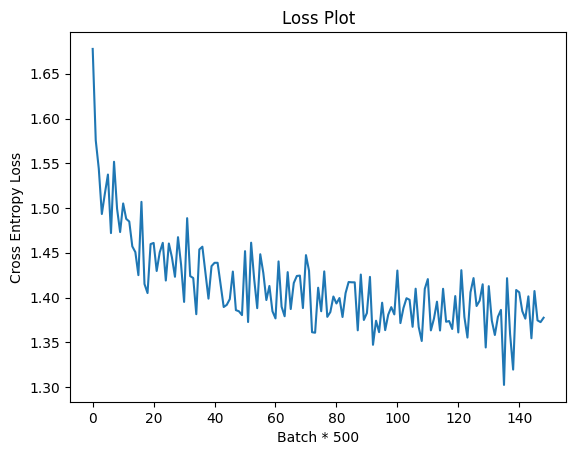

In [ ]:
plt.plot(loss_running_list_encoder[1:])
plt.title("Loss Plot")
plt.xlabel("Batch * 500")
plt.ylabel("Cross Entropy Loss")

Accuracy of the network on the val images: 44 %


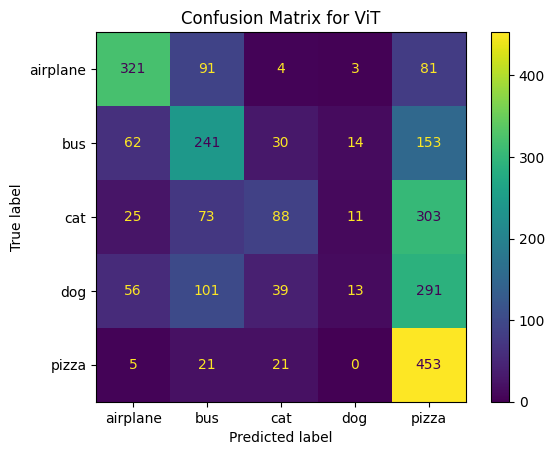

In [ ]:
### Test performance of ViT on val data ###
correct = 0
total = 0
y_pred = []
y_label = []
mapping = { 0: 'airplane',
            1: 'bus',
            2: 'cat',
            3: 'dog',
            4: 'pizza'}


with torch.no_grad():
    for n, data in enumerate(my_val_dataloader):
        images, labels = data
        images = images.to(device)
        outputs = encoder(images)

        predicted = torch.max(outputs.data) 
        predicted_class = torch.argmax(outputs.data)

        total += labels.size(0) #add to total count of ground truth images so we can calculate total accuracy
        #print("total images in val set", total)
        for n, i in enumerate(labels):
            temp = np.array(i) #arrays are one hot encoded, we need to convert it into a human readable label for
            #display in the confusion matrix
            label_arg = np.argmax(temp) #get the argument of the one hot encoding
            y_label.append(mapping[label_arg]) #apply the argument to the mapping dictionary above. For example
            # if the argument is 3, then, that corresponds to a label of dog in the mapping dictionary
            t = int(predicted_class) #get integer representation of prediction from network (will 
            #be an int from 0 to 4. 
            y_pred.append(mapping[t]) #append the predicted output of this label to the prediction list, but, 
            #via the mapping dictionary definition so that the y_pred list is human readable. 

            if label_arg == t:
                correct = correct + 1 #add to total count of correct predictions so we can calculate total accuracy
            

print('Accuracy of the network on the val images: %d %%' % (
    100 * correct / total))
from sklearn.metrics import confusion_matrix

y_true = y_label
y_pred = y_pred
confusion_matrix=confusion_matrix(y_true, y_pred, labels = [ "airplane", "bus", "cat", "dog", "pizza"])
disp = ConfusionMatrixDisplay(confusion_matrix, display_labels = [ "airplane", "bus", "cat", "dog", "pizza"])
disp.plot()
disp.ax_.set_title("Confusion Matrix for ViT")
plt.show()
